In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class AtomoNeutro:
  """
  Instancia un atomo para interaccion Van der waals
  """
  def __init__(self, Radio, RadioConfinamiento):
    """
    Radio              : Radio de la particula interactuante
    RadioConfinamiento : Recibe radio de la region en que se immersa la particula
    """
    self.radio     = Radio
    self.radioconf = RadioConfinamiento
    self.pos       = self.PosicionInicial()
    self.sigma     = 2.556                                                       # Parametro de la interaccion de Van der waals
    self.e         = 10.22                                                       # Parametro de la interaccion de Van der waals

  def PosicionInicial(self):
    """
    Genera un punto interno al radio de confinamiento, alejado de los bordes
    """
    while True:
      Theta = np.random.uniform(0,np.pi)
      Phi = np.random.uniform(0,2*np.pi)
      pos = [(self.radioconf-self.radio)*np.cos(Phi)*np.sin(Theta), (self.radioconf-self.radio)*np.sin(Phi)*np.sin(Theta), (self.radioconf-self.radio)*np.cos(Theta)]
      pos = np.array(pos) * np.random.uniform(0,1)
      if np.linalg.norm(pos) < self.radioconf-2*self.radio:
        return pos

  def Distancia(self, otro):
    """
    Dado otro objeto de AtomoHelio, calcula la distancia entre estos
    """
    return np.linalg.norm(self.pos - otro.pos)

  def EnergiaPotencial(self, otro):
    """
    Calcula la energia potencial entre dos particulas
    """
    r = self.Distancia(otro)
    if r < 2*self.radio:                                                         # Evita que los atomos interactuen si se solapan
      return np.inf
    else:
      a = 4 * self.e * ((self.sigma/r)**12 - (self.sigma/r)**6)
      return a

In [ ]:
class GasNeutroMC:
  """
  Instancia un set de objetos AtomoNeutro para modelar la interaccion entre estos por probabilidad y modelo de MC metropolis
  """
  def __init__(self, NumeroAtomos, RadioConfinamiento, Temperatura, Iteraciones, step, File=False):
    """
    NumeroAtomos       : Numero de atomos a interactuar
    RadioConfinamiento : Radio de confinamiento para el sistema
    Temperatura        : Temperatura del sistema
    Iteraciones        : Numero de iteraciones de MC
    step               : Tamaño de saltos de MC
    File               : Ruta especifica para guardar la informacion espacial del sistema
    """
    self.num_part = NumeroAtomos
    self.resfera  = RadioConfinamiento
    self.T        = Temperatura
    self.k_b      = 1
    self.iter     = Iteraciones
    self.step     = step
    self.atoms    = [AtomoNeutro(0.5, self.resfera) for _ in range(self.num_part)]
    self.Energy   = np.zeros(self.iter)
    if File:
      self.export   = File
    else:
      self.export   = '/content/MCN_A{}_R{}_T{}_Iter{}.txt'.format(self.num_part, self.resfera, self.T, self.iter)

  def Energia(self):
    """
    Calcula la energia de una configuracion particular
    """
    totalE = 0
    for i in range(self.num_part):
      for j in range(i+1, self.num_part):
        totalE += self.atoms[i].EnergiaPotencial(self.atoms[j])
    return totalE

  def Boundary(self, atom):
    """
    Condicion de limite para atomos confinados
    """
    return np.linalg.norm(atom.pos) > self.resfera

  def Posiciones(self):
    """
    Se uso en version anterior al codigo y me da miedo quitarla xd
    """
    c = [atom.pos for atom in self.atoms]
    return c

  def Mover(self):
    """
    Realiza la evolucion por iteracion del sistema
    """
    C = np.zeros((self.num_part, 3))
    self.Pos = np.zeros((self.iter, self.num_part, 3))
    for s in range(self.iter):
      A = self.Energia()                                                                                # Energia de la config actual
      for i in range(self.num_part):
        C[i] = (self.atoms[i].pos).copy()                                                               # Posicion de la config actual
        self.atoms[i].pos = C[i] + self.step*(2 * np.random.rand(3) - 1)                                # Posicion de la config posible MC metropolis
        while self.Boundary(self.atoms[i]):
          self.atoms[i].pos = C[i]                                                                      # Devuelve al atomo a su posicion actual si la posible sale del boundary
      B = self.Energia()                                                                                # Calcula la energia de la config posible
      ediff = B - A                                                                                     # Calcula diferencia de energia entre estados
      if ediff <0 or np.random.rand() < np.exp(- np.abs(ediff) / (self.k_b * self.T)):                  # Condicion de aceptacion
        a=1
      else:
        for j in range(self.num_part):                                                                  # Si falla entonces que reescriba la posicion de los atomos como los de la config previa
          self.atoms[j].pos = C[j]
      for i in range(self.num_part):
        self.Pos[s,i,:]=self.atoms[i].pos
      self.Energy[s]=self.Energia()
    return self.Pos

  def XYZ(self):
    """
    Hace el movimiento y crea el archivo txt con las posiciones
    """
    A = self.Mover()
    B = np.round(A,3)
    file = open(self.export, 'w')
    for s in range(iter):
      h = '{}\niter {}'.format(numatom, s)
      for i in range(self.num_part):
        h+= '\nHe'+' '
        for j in range(3):
          h += str(B[s,i,j])+' '
      h += '\n'
      file.write(h)
    file.close()

  def Plot(self):
    """
    Muestra y guarda el grafico de energia por iteracion para verificar movimiento a configuraciones estables
    """
    self.XYZ()
    plt.plot(np.arange(self.iter-1), self.Energy[1:])
    plt.xlabel('Iteraciones')
    plt.ylabel('Energia total del sistema')
    plt.title('{} He interactuantes por Van der waals MC a {}K\n {} iteraciones'.format(self.num_part, self.T ,self.iter))
    plt.savefig('/content/MCN_A{}_R{}_T{}_Iter{}.png'.format(self.num_part, self.resfera, self.T, self.iter))
    return plt.plot(np.arange(self.iter-1), self.Energy[1:])

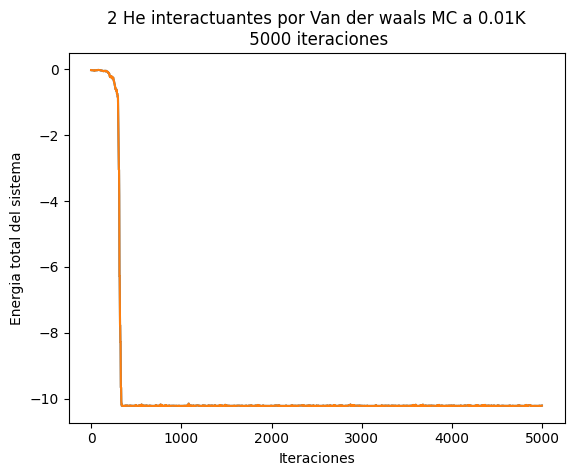

In [ ]:
numatom = 2
radio   = 10
iter = 5000
step = 0.1

A = GasNeutroMC(NumeroAtomos = numatom, RadioConfinamiento=radio, Temperatura=0.01, Iteraciones=iter, step=step)
A.Plot()